# Project PACED

## introduction

Database of chemical time-series concentration data from 567 studies in humans or test animals for 144 environmentally-relevant chemicals and their metabolites (187 analytes total).   
3 parameters : toxicological hazard (dose needed to cause an adverse efect), exposure (occurrence, duration, route, and aggregate dose received) and toxicokinetics (or pharmacokinetic which involve ADME aspects).   
Problems for machine learning's results : human genetic variation   
To select the studies for the database, they used a machine learning model (NLC) of classification (2 classes: yes or no) to select relevent studies : dataset for the NLC training and validation is constituted only with some filtered key words encoded in TF-IDF matrix, coming from the abstracts of the studies. Population = 527 No (86%), 84 yes (14%) --> Huge difference of proportion, cautious with potential bias. They used a bunch of classifiers from scikit learn to predict if a study is relevent or not.   

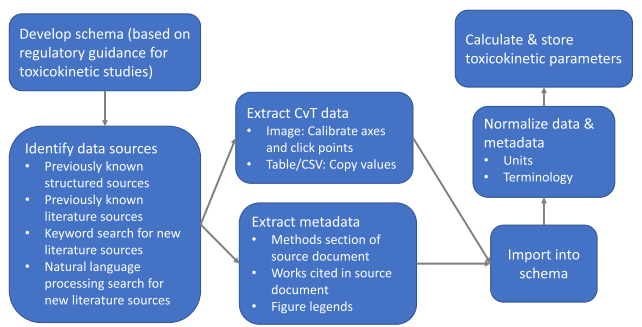

In [1]:
from IPython.display import display, Image
display(Image(filename='images/dataset_building.png'))

Features: dosis (mg/kg)

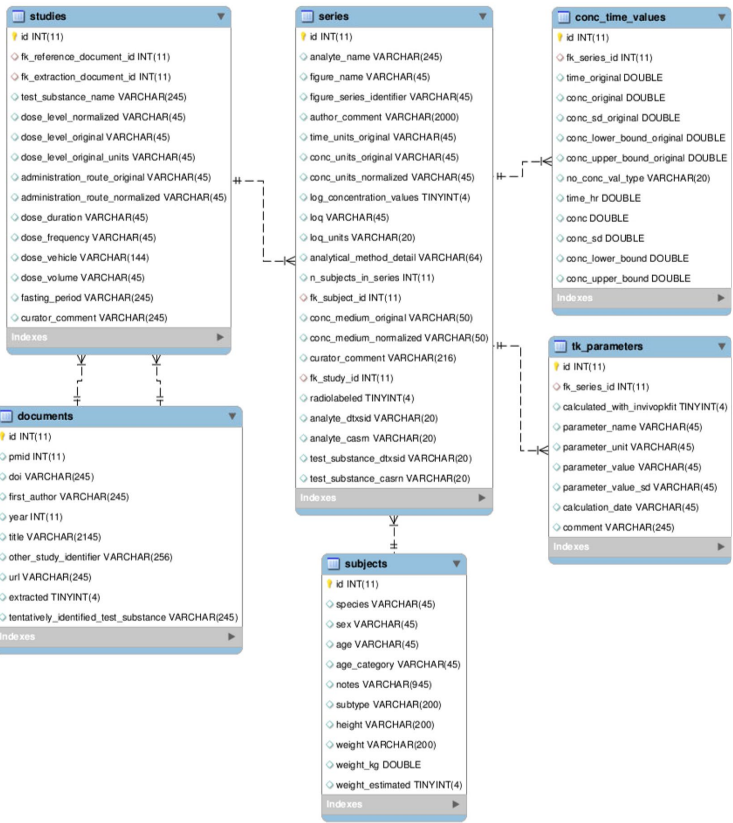

In [2]:
display(Image(filename='images/datasets.png'))

## libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## load datasets

In [4]:
chemical = pd.read_csv('Dataset/chemicals.csv', sep='|',index_col='id' )
ctv = pd.read_csv('Dataset/conc_time_values.csv', sep='|', index_col='id')
doc = pd.read_csv('Dataset/documents.csv', sep='|', index_col='id')
seri = pd.read_csv('Dataset/series.csv', sep='|', index_col='id')
stud = pd.read_csv('Dataset/studies.csv', sep='|', index_col='id')
subjects = pd.read_csv('Dataset/subjects.csv', sep='|', index_col='id')
tk =  pd.read_csv('Dataset/tk_parameters.csv', sep='|', index_col='id')

## Merging Datapoints to one 

In [5]:
df = stud[
    [ # relevant stud columns
        "fk_dosed_chemical_id",
        "dose_duration",
        "dose_level_normalized",
        "administration_route_normalized",
        "dose_duration",
    ]
]
df.index.name = "fk_study_id"
df

,fk_dosed_chemical_id,dose_duration,dose_level_normalized,administration_route_normalized,dose_duration
fk_study_id,,,,,
1,124,95 min,200.0,inhalation,95 min
2,124,95 min,500.0,inhalation,95 min
3,124,95 min,800.0,inhalation,95 min
4,125,2 hr,NaN,inhalation,2 hr
5,125,2 hr,NaN,inhalation,2 hr
...,...,...,...,...,...
1874,78,NaN,100.0,oral,NaN
1875,78,NaN,400.0,oral,NaN
1928,31,NaN,100.0,oral,NaN


In [6]:
df.loc[seri.fk_study_id] # this throws no errors
seri_stud = pd.merge(seri, df, left_on="fk_study_id", right_on="fk_study_id")
seri_stud.index = seri.index
drop = [
    "time_units_original",
    "conc_units_original",
    'figure_name',
       'figure_series_identifier','log_concentration_values', 'loq', 'loq_units',
       "conc_medium_original",
]

seri_stud = seri_stud.drop(columns = drop)
seri_stud

,analyte_name_original,fk_analyzed_chemical_id,author_comment,conc_units_normalized,analytical_method_detail,n_subjects_in_series,fk_subject_id,conc_medium_normalized,curator_comment,fk_study_id,...,analyte_dtxsid,analyte_casrn,test_substance_dtxsid,test_substance_casrn,fk_test_chemical_id,fk_dosed_chemical_id,dose_duration,dose_level_normalized,administration_route_normalized,dose_duration
id,,,,,,,,,,,,,,,,,,,,,
1,Solvent red1,1.0,mean values,NaN,NaN,6.0,1,blood,NaN,1157,...,DTXSID3061635,1229-55-6,DTXSID3061635,1229-55-6,1,1,NaN,20.0,oral,NaN
2,musk moskene,2.0,"30 embryos in 2 petri dishes, multiple data po...",NaN,NaN,30.0,2,NaN,NaN,1158,...,DTXSID6044519,116-66-5,DTXSID6044519,116-66-5,2,2,10 days,NaN,dermal,10 days
3,[14]C,256.0,NaN,NaN,NaN,4.0,3,blood,NaN,1159,...,DTXSID20873970,14762-75-5,DTXSID7031290,54464-57-2,3,3,NaN,20.0,oral,NaN
4,[14]C,256.0,NaN,NaN,NaN,4.0,3,adipose,NaN,1159,...,DTXSID20873970,14762-75-5,DTXSID7031290,54464-57-2,3,3,NaN,20.0,oral,NaN
5,[14]C,256.0,NaN,NaN,NaN,4.0,3,muscle,NaN,1159,...,DTXSID20873970,14762-75-5,DTXSID7031290,54464-57-2,3,3,NaN,20.0,oral,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,Emodin,65.0,NaN,NaN,NaN,1.0,36185,plasma,NaN,1841,...,DTXSID5025231,518-82-1,DTXSID5025231,518-82-1,65,65,NaN,80.0,oral,NaN
32408,Emodin,65.0,NaN,NaN,NaN,1.0,36185,plasma,NaN,1841,...,DTXSID5025231,518-82-1,DTXSID5025231,518-82-1,65,65,NaN,80.0,oral,NaN
32409,Emodin,65.0,NaN,NaN,NaN,1.0,36185,plasma,NaN,1841,...,DTXSID5025231,518-82-1,DTXSID5025231,518-82-1,65,65,NaN,80.0,oral,NaN


In [7]:
print(len(ctv))
ctv = ctv[ctv.fk_series_id.notna()] #0.04% 
print(len(ctv))
ctv.fk_series_id = ctv.fk_series_id.astype(int)
ctv.describe(include="all")
ctv.drop(columns=[
    "conc_sd",
    	"conc_lower_bound",
    	"conc_upper_bound", 
     "time_original",	"conc_original",	"conc_sd_original"	
])

df = pd.merge(ctv, seri_stud, left_on="fk_series_id", right_index=True)


#fix duplitaced column
a = df.dose_duration.iloc[:,0]
df = df.drop(columns="dose_duration")
df["dose_duration"] = a
df.dose_duration.isna().mean()

df

38675
38657


,fk_series_id,time_original,conc_original,conc_sd_original,conc_lower_bound_original,conc_upper_bound_original,no_conc_val_type,time_hr,conc,conc_sd,...,radiolabeled,analyte_dtxsid,analyte_casrn,test_substance_dtxsid,test_substance_casrn,fk_test_chemical_id,fk_dosed_chemical_id,dose_level_normalized,administration_route_normalized,dose_duration
id,,,,,,,,,,,,,,,,,,,,,
1,1,0.069826,2.618893,NaN,NaN,NaN,NaN,0.06982,0.00261,NaN,...,NaN,DTXSID3061635,1229-55-6,DTXSID3061635,1229-55-6,1,1,20.0,oral,NaN
2,1,0.239928,122.156713,NaN,NaN,NaN,NaN,0.23992,0.12215,NaN,...,NaN,DTXSID3061635,1229-55-6,DTXSID3061635,1229-55-6,1,1,20.0,oral,NaN
3,1,0.407653,340.571116,47.781570,NaN,NaN,NaN,0.40765,0.34057,NaN,...,NaN,DTXSID3061635,1229-55-6,DTXSID3061635,1229-55-6,1,1,20.0,oral,NaN
4,1,0.766816,990.431853,76.792296,NaN,NaN,NaN,0.76681,0.99043,NaN,...,NaN,DTXSID3061635,1229-55-6,DTXSID3061635,1229-55-6,1,1,20.0,oral,NaN
5,1,1.066636,510.409394,54.607509,NaN,NaN,NaN,1.06663,0.51040,NaN,...,NaN,DTXSID3061635,1229-55-6,DTXSID3061635,1229-55-6,1,1,20.0,oral,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123077,32410,2.232525,2.160360,NaN,NaN,NaN,NaN,2.23252,2.16035,NaN,...,NaN,DTXSID4020533,123-91-1,DTXSID4020533,123-91-1,13,13,10.0,iv,NaN
123078,32411,0.000000,2.298093,NaN,NaN,NaN,NaN,0.00000,2.29809,NaN,...,NaN,DTXSID4020533,123-91-1,DTXSID4020533,123-91-1,13,13,3.0,iv,NaN
123079,32411,0.668434,1.931652,NaN,NaN,NaN,NaN,0.66843,1.93165,NaN,...,NaN,DTXSID4020533,123-91-1,DTXSID4020533,123-91-1,13,13,3.0,iv,NaN


In [8]:
tk

,fk_series_id,fk_study_id,fk_chemical_id,calculated_with_invivopkfit,parameter_name,parameter_unit,parameter_value,parameter_value_sd,calculation_date,comment,joint_analysis_studies,reason_for_omittal,loglikelihood,AIC
id,,,,,,,,,,,,,,
1,1.0,NaN,NaN,0,AUC,NaN,1060.634083,NaN,2018-08-08 16:26:46.214162,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,0,AUC,NaN,1855.049021,NaN,2018-08-08 16:26:46.214662,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,0,AUC,NaN,24276.000000,NaN,2018-08-08 16:26:46.215663,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,0,AUC,NaN,65794.000000,NaN,2018-08-08 16:26:46.217665,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN
5,5.0,NaN,NaN,0,AUC,NaN,32276.000000,NaN,2018-08-08 16:26:46.218666,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8004,NaN,1193.0,NaN,1,kgutabs,1/hr,425.722211,NaN,22-Oct-20,1compartment analytic fitted geometric mean ca...,NaN,NaN,-32.242400,72.48470
8006,NaN,1536.0,NaN,1,kgutabs,1/hr,5.393781,NaN,22-Oct-20,1compartment analytic fitted geometric mean ca...,NaN,NaN,-22.521200,53.04240
8007,NaN,1537.0,NaN,1,kgutabs,1/hr,4.858586,NaN,22-Oct-20,1compartment analytic fitted geometric mean ca...,NaN,NaN,-26.795800,61.59160


In [9]:
tk = tk[["parameter_name", "parameter_value", "fk_series_id", "fk_study_id"]]
df = df.merge(tk.drop(columns="fk_study_id"), on="fk_series_id", how="left")
# .merge(tk.drop(columns = "fk_series_id"), how="left")

In [10]:
df.fk_subject_id

0         1
1         1
2         1
3         1
4         1
         ..
39498    14
39499    14
39500    14
39501    14
39502    14
Name: fk_subject_id, Length: 39503, dtype: int64

In [11]:
seri.columns

Index(['analyte_name_original', 'fk_analyzed_chemical_id', 'figure_name',
       'figure_series_identifier', 'author_comment', 'time_units_original',
       'conc_units_original', 'conc_units_normalized',
       'log_concentration_values', 'loq', 'loq_units',
       'analytical_method_detail', 'n_subjects_in_series', 'fk_subject_id',
       'conc_medium_original', 'conc_medium_normalized', 'curator_comment',
       'fk_study_id', 'radiolabeled', 'analyte_dtxsid', 'analyte_casrn',
       'test_substance_dtxsid', 'test_substance_casrn', 'fk_test_chemical_id'],
      dtype='object')

In [12]:
df = df.merge(subjects, left_on="fk_subject_id", right_index=True, how = "left")
df

,fk_series_id,time_original,conc_original,conc_sd_original,conc_lower_bound_original,conc_upper_bound_original,no_conc_val_type,time_hr,conc,conc_sd,...,species,sex,age,age_category,notes,subtype,height,weight,weight_kg,weight_estimated
0,1,0.069826,2.618893,NaN,NaN,NaN,NaN,0.06982,0.00261,NaN,...,rat,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0
1,1,0.239928,122.156713,NaN,NaN,NaN,NaN,0.23992,0.12215,NaN,...,rat,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0
2,1,0.407653,340.571116,47.781570,NaN,NaN,NaN,0.40765,0.34057,NaN,...,rat,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0
3,1,0.766816,990.431853,76.792296,NaN,NaN,NaN,0.76681,0.99043,NaN,...,rat,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0
4,1,1.066636,510.409394,54.607509,NaN,NaN,NaN,1.06663,0.51040,NaN,...,rat,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39498,32410,2.232525,2.160360,NaN,NaN,NaN,NaN,2.23252,2.16035,NaN,...,rat,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0
39499,32411,0.000000,2.298093,NaN,NaN,NaN,NaN,0.00000,2.29809,NaN,...,rat,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0
39500,32411,0.668434,1.931652,NaN,NaN,NaN,NaN,0.66843,1.93165,NaN,...,rat,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0
39501,32411,1.120579,1.637999,NaN,NaN,NaN,NaN,1.12057,1.63799,NaN,...,rat,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0


In [13]:
analyte_name_to_series = df.value_counts(["analyte_name_original", "fk_series_id"]).reset_index().groupby(
    "analyte_name_original"
).fk_series_id.apply(list).to_dict()

Missing Concs very bad

In [14]:
df[["fk_series_id", "time_hr", "conc", "fk_subject_id",]].isna().mean()

fk_series_id     0.000000
time_hr          0.000000
conc             0.372276
fk_subject_id    0.000000
dtype: float64

In [15]:
df = df[df.conc.notna()]

In [16]:
df = df.drop_duplicates(["fk_series_id", "time_hr", "conc", "fk_subject_id",])
df[["fk_series_id", "time_hr", "conc", "fk_subject_id",]].isna().mean()

fk_series_id     0.0
time_hr          0.0
conc             0.0
fk_subject_id    0.0
dtype: float64

Saving to dataset as cleaned

In [17]:
counts = df.value_counts("fk_series_id")
mask = counts > 2
relevant = counts[mask]
mask = df.fk_series_id.apply(lambda x : x in set(relevant.index))
df = df[mask]
df["series_length"] = relevant.loc[df.fk_series_id].values
df.to_csv("Dataset/cleaned.csv")
df

,fk_series_id,time_original,conc_original,conc_sd_original,conc_lower_bound_original,conc_upper_bound_original,no_conc_val_type,time_hr,conc,conc_sd,...,sex,age,age_category,notes,subtype,height,weight,weight_kg,weight_estimated,series_length
0,1,0.069826,2.618893,NaN,NaN,NaN,NaN,0.06982,0.00261,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0,16
1,1,0.239928,122.156713,NaN,NaN,NaN,NaN,0.23992,0.12215,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0,16
2,1,0.407653,340.571116,47.781570,NaN,NaN,NaN,0.40765,0.34057,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0,16
3,1,0.766816,990.431853,76.792296,NaN,NaN,NaN,0.76681,0.99043,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0,16
4,1,1.066636,510.409394,54.607509,NaN,NaN,NaN,1.06663,0.51040,NaN,...,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2000,0.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39498,32410,2.232525,2.160360,NaN,NaN,NaN,NaN,2.23252,2.16035,NaN,...,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0,3
39499,32411,0.000000,2.298093,NaN,NaN,NaN,NaN,0.00000,2.29809,NaN,...,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0,4
39500,32411,0.668434,1.931652,NaN,NaN,NaN,NaN,0.66843,1.93165,NaN,...,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0,4
39501,32411,1.120579,1.637999,NaN,NaN,NaN,NaN,1.12057,1.63799,NaN,...,male,NaN,NaN,albino,Sprague Dawley,NaN,200-285 g,0.2425,2.0,4


In [40]:
n_unique = lambda x: len(np.unique(x))
common = df.groupby("analyte_name_original").agg({"fk_series_id" : n_unique,"dose_level_normalized": n_unique,"series_length": "count"})
common = common.sort_values("series_length", ascending=False)
common

,fk_series_id,dose_level_normalized,series_length
analyte_name_original,,,
[14]C,78,9,485
tertiary amyl alcohol,12,1,466
trichloroethylene,42,8,441
tertiary amyl methyl ether,12,1,386
trichloroacetic acid,35,5,382
...,...,...,...
Carbendazim,1,1,7
chloroform,1,1,7
Antipyrine,1,1,7


In [32]:
df.time_hr = pd.to_timedelta(df.time_hr, unit = "hours")

<Axes: ylabel='Frequency'>

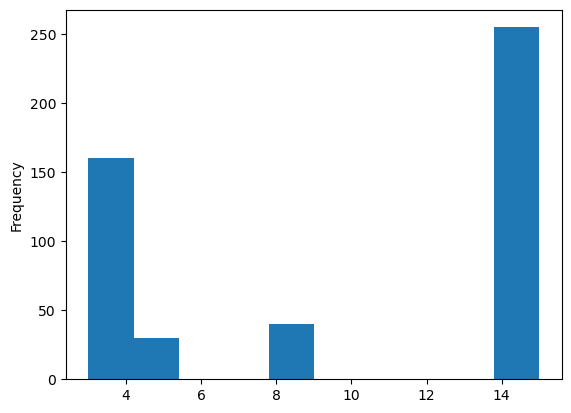

In [35]:
compund = "[14]C"	
selection = df.query("analyte_name_original == @compund")
selection.series_length.plot.hist()

In [24]:
series.columns

Index(['fk_series_id', 'time_original', 'conc_original', 'conc_sd_original',
       'conc_lower_bound_original', 'conc_upper_bound_original',
       'no_conc_val_type', 'time_hr', 'conc', 'conc_sd', 'conc_lower_bound',
       'conc_upper_bound', 'analyte_name_original', 'fk_analyzed_chemical_id',
       'author_comment', 'conc_units_normalized', 'analytical_method_detail',
       'n_subjects_in_series', 'fk_subject_id', 'conc_medium_normalized',
       'curator_comment', 'fk_study_id', 'radiolabeled', 'analyte_dtxsid',
       'analyte_casrn', 'test_substance_dtxsid', 'test_substance_casrn',
       'fk_test_chemical_id', 'fk_dosed_chemical_id', 'dose_level_normalized',
       'administration_route_normalized', 'dose_duration', 'parameter_name',
       'parameter_value', 'species', 'sex', 'age', 'age_category', 'notes',
       'subtype', 'height', 'weight', 'weight_kg', 'weight_estimated',
       'series_length'],
      dtype='object')

In [41]:
selection

,fk_series_id,time_original,conc_original,conc_sd_original,conc_lower_bound_original,conc_upper_bound_original,no_conc_val_type,time_hr,conc,conc_sd,...,sex,age,age_category,notes,subtype,height,weight,weight_kg,weight_estimated,series_length
24,3,4.0,731.00,119.00,NaN,NaN,NaN,0 days 04:00:00,0.71491,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4000,0.0,4
25,3,8.0,843.00,197.00,NaN,NaN,NaN,0 days 08:00:00,0.82445,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4000,0.0,4
26,3,24.0,514.00,32.00,NaN,NaN,NaN,1 days 00:00:00,0.50269,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4000,0.0,4
27,3,48.0,342.00,37.00,NaN,NaN,NaN,2 days 00:00:00,0.33447,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4000,0.0,4
28,4,4.0,2462.00,1061.00,NaN,NaN,NaN,0 days 04:00:00,2.86279,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6831,499,20.0,7.05,0.67,NaN,NaN,NaN,0 days 00:19:59.988000,0.28846,NaN,...,male,NaN,NaN,NaN,B6C3F1,NaN,20-25 g,0.0225,2.0,5
6832,499,40.0,6.72,0.62,NaN,NaN,NaN,0 days 00:39:59.976000,0.27495,NaN,...,male,NaN,NaN,NaN,B6C3F1,NaN,20-25 g,0.0225,2.0,5
6833,499,60.0,5.74,1.29,NaN,NaN,NaN,0 days 01:00:00,0.23486,NaN,...,male,NaN,NaN,NaN,B6C3F1,NaN,20-25 g,0.0225,2.0,5
6834,499,180.0,4.48,0.16,NaN,NaN,NaN,0 days 03:00:00,0.18330,NaN,...,male,NaN,NaN,NaN,B6C3F1,NaN,20-25 g,0.0225,2.0,5


In [42]:
series = selection.query("fk_series_id == 4")

,fk_series_id,time_original,conc_original,conc_sd_original,conc_lower_bound_original,conc_upper_bound_original,no_conc_val_type,time_hr,conc,conc_sd,...,sex,age,age_category,notes,subtype,height,weight,weight_kg,weight_estimated,series_length
28,4,4.0,2462.0,1061.0,NaN,NaN,NaN,0 days 04:00:00,2.86279,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4,0.0,4
29,4,8.0,4403.0,2661.0,NaN,NaN,NaN,0 days 08:00:00,5.11976,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4,0.0,4
30,4,24.0,626.0,291.0,NaN,NaN,NaN,1 days 00:00:00,0.72790,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4,0.0,4
31,4,48.0,360.0,153.0,NaN,NaN,NaN,2 days 00:00:00,0.41860,NaN,...,male,8-12 weeks,adolescent,NaN,Fisher,NaN,400 g,0.4,0.0,4


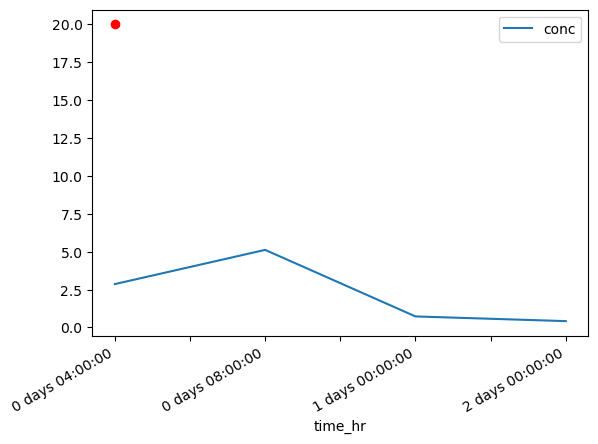

In [43]:
series.plot(x = "time_hr", y = "conc")
plt.scatter([0],[series.dose_level_normalized.iloc[0]], c="red")
series

In [ ]:
def plot_series(ser : pd.DataFrame):
    
    
    

In [85]:
df.analyte_name_original.value_counts()a

analyte_name_original
Hexachlorobenzene              1898
Perfluorooctanoic acid         1851
N-desmethyltamoxifen           1116
Perfluorodecanoic acid         1032
Perfluorohexanoic Acid         1020
                               ... 
chloroform                        7
hippuric acid                     5
Phenolphthalein glucuronide       2
Pentachlorophenol                 2
Pentachloroanisole                2
Name: count, Length: 217, dtype: int64

In [5]:
print(list(chemical.columns))
#print(list(ctv.columns))
#print(list(doc.columns))
#print(list(seri.columns))
#print(list(stud.columns))
#print(list(subjects.columns))
print(list(tk.columns))

['fk_series_id', 'fk_study_id', 'fk_chemical_id', 'calculated_with_invivopkfit', 'parameter_name', 'parameter_unit', 'parameter_value', 'parameter_value_sd', 'calculation_date', 'comment', 'joint_analysis_studies', 'reason_for_omittal', 'loglikelihood', 'AIC']


In [6]:
seri_stud = seri.merge(stud, left_on = 'fk_study_id', right_on = 'id')

In [7]:
print(seri.shape)
print(stud.shape)
print(seri_stud.shape)

(16576, 24)
(572, 15)
(16576, 39)


### stud table

In [8]:
stud.head(2)

,fk_reference_document_id,fk_extraction_document_id,fk_dosed_chemical_id,test_substance_name_original,dose_level_normalized,dose_level_original,dose_level_original_units,administration_route_original,administration_route_normalized,dose_duration,dose_frequency,dose_vehicle,dose_volume,fasting_period,curator_comment
id,,,,,,,,,,,,,,,
1,NaN,229,124,pyrene,200.0,200.0,mg/m^3,inhalation,inhalation,0 days 01:35:00,NaN,NaN,NaN,NaN,free pyrene concentrations available from same...
2,NaN,229,124,pyrene,500.0,500.0,mg/m^3,inhalation,inhalation,0 days 01:35:00,NaN,NaN,NaN,NaN,free pyrene concentrations available from same...


In [9]:
display(stud.administration_route_original.value_counts())
display(stud.administration_route_normalized.value_counts())

administration_route_original
inhalation        156
Gavage            133
iv                 82
IV                 71
po                 47
gavage             33
dermal vapor       15
oral               12
dermal              8
ingestion           4
Repeat IV           2
ip                  2
subcutaneous        2
intratracheal       1
hand immersion      1
feed                1
immersion           1
intra-arterial      1
Name: count, dtype: int64

administration_route_normalized
oral          230
inhalation    157
iv            156
dermal         25
Name: count, dtype: int64

the normalized columns contain a lower number of categories. Can be better understood by a machine learning model

In [10]:
stud.dtypes

fk_reference_document_id                   float64
fk_extraction_document_id                    int64
fk_dosed_chemical_id                         int64
test_substance_name_original                object
dose_level_normalized                      float64
dose_level_original                        float64
dose_level_original_units                   object
administration_route_original               object
administration_route_normalized             object
dose_duration                      timedelta64[ns]
dose_frequency                              object
dose_vehicle                                object
dose_volume                                 object
fasting_period                              object
curator_comment                             object
dtype: object

In [11]:
stud['dose_duration'] = pd.to_timedelta(stud['dose_duration'], errors='coerce')

### chemical

In [12]:
display(chemical.head(2))
chemical.shape

,dsstox_substance_id,dsstox_casrn,preferred_name,chemistry_team_mapping
id,,,,
1,DTXSID3061635,1229-55-6,NaN,1
2,DTXSID6044519,116-66-5,NaN,1


(180, 4)

In [13]:
chemical.dtypes

dsstox_substance_id        object
dsstox_casrn               object
preferred_name            float64
chemistry_team_mapping      int64
dtype: object

In [14]:
display(chemical.count())

dsstox_substance_id       180
dsstox_casrn              180
preferred_name              0
chemistry_team_mapping    180
dtype: int64

The 'preferred_name' columns contains only NaN values. The 'chemistry_team_mapping' column contains only one value, so there is no spécifique information. Those columns doesn't contain any information, so we delete it. 

In [15]:
print(chemical['dsstox_substance_id'].value_counts().count())
print(chemical['dsstox_casrn'].value_counts().count())

180
180


There is three differents columns for molecule's identification ('id', 'dsstox_substance_id' and 'dsstox_casrn'). One would be enough. The chemical 'id' index is used as a column in the tk dataset. This dataset is not interesting for training a model. We wont use it. 

In [16]:
chemical = chemical.drop(['preferred_name', 'chemistry_team_mapping'], axis = 1)

### ctv

In [17]:
display(ctv.tail(3))
print(ctv.shape)

,fk_series_id,time_original,conc_original,conc_sd_original,conc_lower_bound_original,conc_upper_bound_original,no_conc_val_type,time_hr,conc,conc_sd,conc_lower_bound,conc_upper_bound
id,,,,,,,,,,,,
123079,32411.0,0.668434,1.931652,NaN,NaN,NaN,NaN,0.66843,1.93165,NaN,NaN,NaN
123080,32411.0,1.120579,1.637999,NaN,NaN,NaN,NaN,1.12057,1.63799,NaN,NaN,NaN
123081,32411.0,1.569962,1.295943,NaN,NaN,NaN,NaN,1.56996,1.29594,NaN,NaN,NaN


(38675, 12)


In [18]:
ctv.fk_series_id.value_counts().count()

16266

In [19]:
display(ctv.count())  #count all the non-NaN values. The columns originals look not really interesting. We'll keep only the 'conc' and the 'time_hr' values
ctv = ctv[['fk_series_id', 'time_hr','conc']]

fk_series_id                 38657
time_original                38675
conc_original                25590
conc_sd_original              1589
conc_lower_bound_original       78
conc_upper_bound_original       81
no_conc_val_type              5474
time_hr                      38657
conc                         23951
conc_sd                          0
conc_lower_bound                 0
conc_upper_bound                 0
dtype: int64

In [20]:
ctv.describe()

,fk_series_id,time_hr,conc
count,38657.000000,38657.000000,23951.000000
mean,12537.436609,186.437044,218.726618
std,7756.080920,860.871490,2566.476027
min,1.000000,-8.000000,0.000000
25%,8487.000000,0.500000,0.077570
50%,12112.000000,3.000000,0.820000
75%,18429.000000,23.820220,7.600000
max,32411.000000,8760.000000,90000.000000


#### time_hr column

In [21]:
ctv[ctv.time_hr < 0].shape

(1402, 3)

There is 1402 times < 0. It's strange. So we have to deal with it. Several options: remove those or replace. Replace : by 0, trying to replace it with a consistent value.

<Axes: xlabel='time_hr', ylabel='Frequency'>

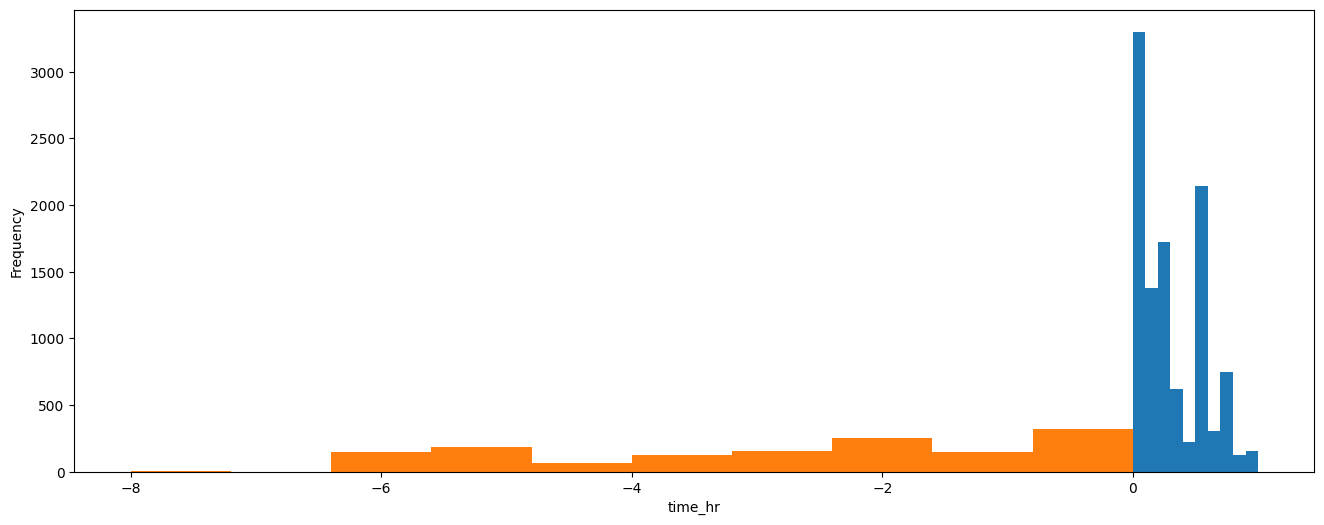

In [22]:
ctv[ctv.time_hr<0].count()  #they have in common a NaN no_conc_val_type 
plt.figure(figsize = (16, 6))
ctv[(ctv.time_hr>=0)&(ctv.time_hr<1)].time_hr.plot(kind = 'hist', xlabel = 'time_hr')
ctv[(ctv.time_hr<0)].time_hr.plot(kind = 'hist', xlabel = 'time_hr')

In [23]:
display(ctv[ctv.time_hr<0].fk_series_id.value_counts())
ctv.fk_series_id.value_counts()

fk_series_id
523.0      33
23630.0    30
23574.0    30
23575.0    30
23576.0    29
           ..
462.0       1
460.0       1
454.0       1
446.0       1
452.0       1
Name: count, Length: 216, dtype: int64

fk_series_id
523.0      56
522.0      49
23630.0    45
23605.0    45
524.0      45
           ..
21224.0     1
21223.0     1
21222.0     1
21220.0     1
18819.0     1
Name: count, Length: 16266, dtype: int64

In [24]:
rm_neg_t = pd.Series({k: len(ctv.loc[ctv.fk_series_id == k]) for k in ctv[ctv.time_hr < 0].fk_series_id.value_counts().index}, name='count_negative_times')
rm_neg_t = pd.DataFrame({'time_count_by_serie': rm_neg_t, 'negative_time_count_by_serie': ctv[ctv.time_hr<0].fk_series_id.value_counts()})
rm_neg_t['proportion_of_negative_time']= rm_neg_t.negative_time_count_by_serie / rm_neg_t.time_count_by_serie
rm_neg_t = rm_neg_t.sort_values(by='proportion_of_negative_time', ascending=False)
display(rm_neg_t[rm_neg_t.proportion_of_negative_time>0.4].describe())  #certain series seem to bring together a large number of negative times (which are doubtful values)
series_to_remove_from_ctv = np.array(rm_neg_t[rm_neg_t.proportion_of_negative_time>0.4].index)

,time_count_by_serie,negative_time_count_by_serie,proportion_of_negative_time
count,101.000000,101.000000,101.000000
mean,17.970297,10.316832,0.586137
std,12.633650,7.829343,0.159089
min,4.000000,2.000000,0.406250
25%,7.000000,4.000000,0.454545
50%,13.000000,7.000000,0.533333
75%,24.000000,16.000000,0.666667
max,56.000000,33.000000,1.000000


In [25]:
ctv = ctv.drop(ctv[ctv['fk_series_id'].isin(series_to_remove_from_ctv)].index)
ctv['time_hr'] = ctv.time_hr.apply(lambda x: 0 if x<0 else x) #we replace the 316 remaining negative values by 0

#### conc column

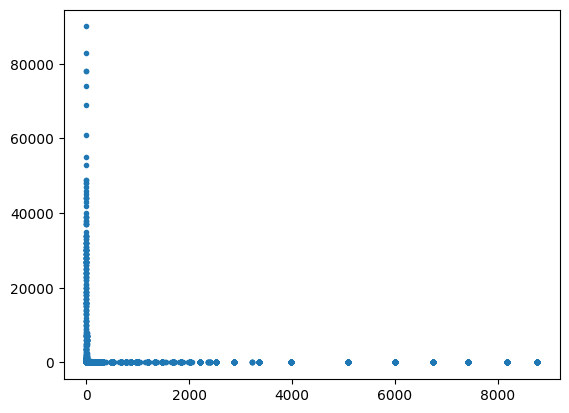

In [26]:
plt.plot(ctv.time_hr, ctv.conc, '.')

In [27]:
ctv[ctv.time_hr>6000].time_hr.value_counts()

time_hr
6744.0    75
8760.0    75
8184.0    74
7416.0    72
Name: count, dtype: int64

some substances can stay in a living thing for a long time at a high concentration. We can't just delete these lines

Text(0, 0.5, 'concentration')

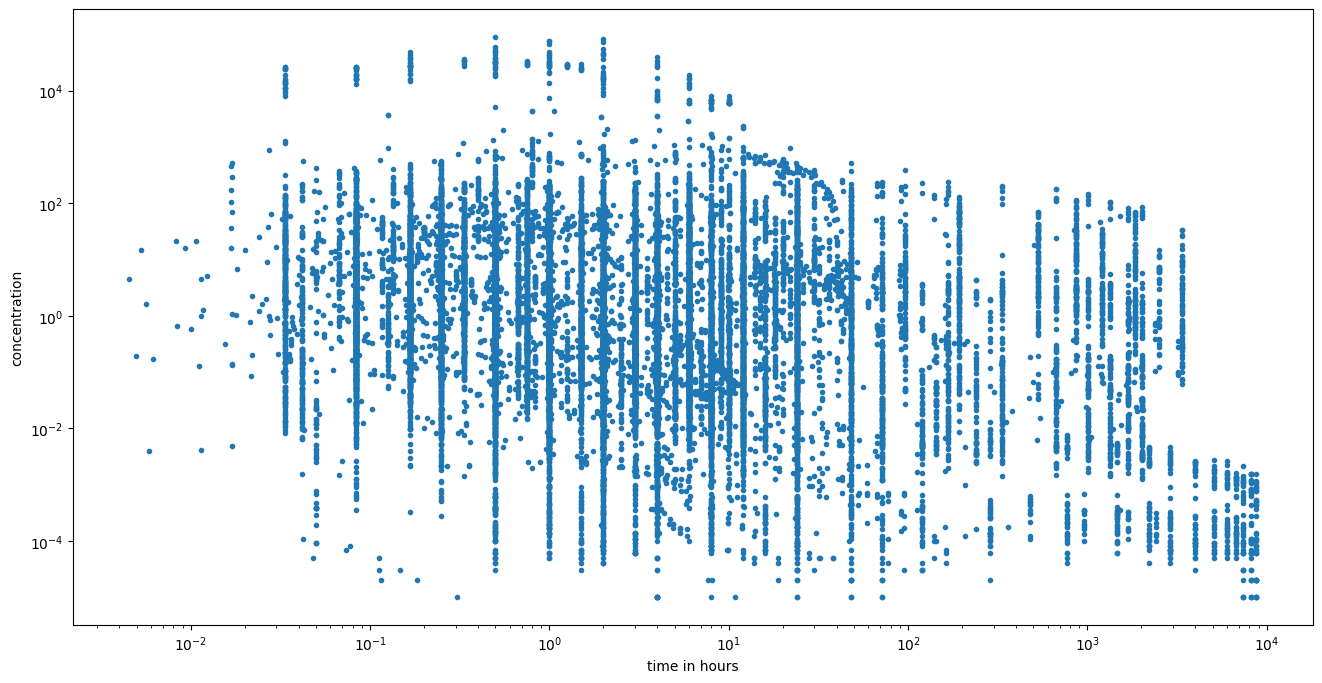

In [28]:
plt.figure(figsize = (16, 8))
plt.plot(ctv.time_hr, ctv.conc, '.')
plt.xscale('log')
plt.xlabel('time in hours')
plt.yscale('log')
plt.ylabel('concentration')

### subjects

In [29]:
print(subjects.shape)
display(subjects.head(2))
display(subjects.describe())
subjects.sex = ['male' if k == 'Male' else 'female' if k=='Female' else k for k in subjects.sex]
display(subjects.sex.value_counts())   #there was 4 categories Male, Female, male, female. We reduced it to have two categories : male and female. 

(7301, 10)


,species,sex,age,age_category,notes,subtype,height,weight,weight_kg,weight_estimated
id,,,,,,,,,,
1,rat,NaN,NaN,NaN,"half male, half female; healthy and drug-free",Sprague Dawley,NaN,200 ± 20 g,0.2,0.0
2,frog,NaN,embyro,NaN,NaN,xenopus laevis,NaN,NaN,NaN,NaN


,weight_kg,weight_estimated
count,6072.000000,6092.000000
mean,0.528008,0.158076
std,4.491755,0.391330
min,0.021433,0.000000
25%,0.180000,0.000000
50%,0.251100,0.000000
75%,0.288000,0.000000
max,87.000000,2.000000


sex
female    3652
male      3630
Name: count, dtype: int64

The species columns has a lot of species wich only appeared 1 time which is few compared to total. But, the weight can be hard to compare for a computer and the bodies responses can also be very differents because there is a huge gap between a frog and a dog. It means that maybe we'll have to delete the 'other' categorie later. 

In [30]:
subjects.species = ['other' if k in ['mouse', 'rabbit', 'frog', 'dog', 'monkey'] else 'rat' if k == 'Rat' else k for k in subjects.species]
display(subjects.species.value_counts(normalize = True))

species
rat        0.839474
Mouse      0.139707
Hamster    0.013971
human      0.004794
other      0.002055
Name: proportion, dtype: float64

the column age is not meaningful because it give the age of the subjects with a time, but for exemple, 120 days means something very different for a mouse and for a humain. So we will prefer the column age_category and drop the other one. 

In [31]:
display(subjects.age.value_counts())
subjects.drop('age', axis = 1, inplace = True)
display(subjects.age_category.value_counts())

age
adult                       58
120 days                     4
8-9 weeks old                4
21-24 years old              3
19-28 yo                     3
10 weeks old, adolescent     2
27 yr                        2
22-32 yr                     2
>7 weeks                     2
12 weeks                     2
26 yr                        2
young adult                  1
5 months                     1
26-54 years (mean 43)        1
adult (23-29y)               1
adult                        1
9-15 weeks                   1
8-10 weeks                   1
10-11 weeks                  1
7-8 weeks                    1
20-36 yo (mean 26.6)         1
7-9 weeks                    1
31 days                      1
10 weeks                     1
6 week old                   1
22 yr                        1
23 yr                        1
23                           1
20-36 yo (mean 25.3)         1
35 or 46 yrs                 1
24-46 yrs (mean 38)          1
20 days                      1
35-5

age_category
adult          99
adolescent     12
young_adult     6
child           3
infant          2
Name: count, dtype: int64

In [32]:
subjects.notes.value_counts() #too many categories to make a classification, but maybe the model can find patterns in the notes, so we keep those for the moment

notes
jugular vein catheter    48
7                        28
15                       28
12                       28
11                       28
                         ..
T15U1                     1
T15U2                     1
T15U3                     1
T15V2                     1
V9_Z891                   1
Name: count, Length: 3424, dtype: int64

In [33]:
subjects.subtype = ['F344' if k in ['F344', 'F344 ', 'F344 - this seems too small','Fischer-344', '344', 'Fisher', 'Fischer-344', 'F344 (Charles River)', 'F344 (Harlan Winkelmann)'] 
                    else 'F344/N' if k in ['F344/N','F344/N ']
                    else 'Syrian Golden' if k == 'Syrian Golden' 
                    else 'B6C3F1' if k == 'B6C3F1' 
                    else 'Harlan Sprague Dawley' if  k in ['Harlan Sprague Dawley','Spraque-Dawley','Sprague-Dawley','Sprague Dawley','Harlan Sprague-Dawley','Harlan Sprague Dawley ', 'Harlan Sprague Dawley - this seems too small']
                    else 'other' for k in subjects.subtype]

We have only 9 non NaN values for the height column. So it doesn't bring a lot of information. weigth not in kg can be dropped too. 

In [34]:
subjects[subjects.height.isna() == False]

,species,sex,age_category,notes,subtype,height,weight,weight_kg,weight_estimated
id,,,,,,,,,
12,human,male,adult,NaN,other,180-190 cm,55-90 kg,72.5000,2.0
16,human,male,adult,"healthy, nonsmoker, no drug use, no violent ex...",other,170-189 cm (mean 178),72.6-90.7 kg (mean 83.1),83.1000,2.0
17,human,male,adult,body surface area 2.00+/-0.16 m^2,other,182+/-9 cm,79+/-10 kg,79.0000,2.0
39,human,male,adult,NaN,other,176 or 180 cm,69 or 73 kg,71.0000,2.0
63,human,NaN,adult,"3 males, 3 females in each experiment, asked t...",other,162-185 cm,56-93 kg,74.5000,2.0
64,human,male,adult,asked to refrain from alcohol/drugs and refuel...,other,175-185 cm,62-93 kg,77.5000,2.0
66,human,male,adult,"students, healthy",other,176.8 ± 4.3 cm,74.5 ± 5.7 kg,74.5000,2.0
67,human,male,adult,"students, healthy",other,178.3 ± 5.2 cm,70.0 ± 6.3 kg,70.0000,2.0
81,human,male,adult,subject id 210,other,70 in,134 lb,60.7814,0.0


In [35]:
subjects.drop(['height', 'weight'], axis = 1, inplace = True)

### doc

In [36]:
print(doc.shape)
display(doc.head(3))
display(doc.describe())

(24702, 13)


,pmid,doi,first_author,year,title,other_study_identifier,url,extracted,tentatively_identified_test_substance,machine_confidence,tsca,fifra,toxcast
id,,,,,,,,,,,,,
1,43370.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
2,422270.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
3,422271.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN


,pmid,year,title,extracted,machine_confidence,tsca,fifra,toxcast
count,2.464500e+04,29.000000,0.0,24702.000000,24520.000000,13396.0,4707.0,4990.0
mean,1.473335e+07,1999.482759,NaN,0.009149,0.920518,1.0,1.0,1.0
std,9.048089e+06,9.664444,NaN,0.117999,0.089591,0.0,0.0,0.0
min,4.220000e+02,1982.000000,NaN,0.000000,0.777778,1.0,1.0,1.0
25%,7.600944e+06,1991.000000,NaN,0.000000,0.888889,1.0,1.0,1.0
50%,1.460028e+07,2002.000000,NaN,0.000000,1.000000,1.0,1.0,1.0
75%,2.270442e+07,2008.000000,NaN,0.000000,1.000000,1.0,1.0,1.0
max,3.100993e+07,2018.000000,NaN,3.000000,1.000000,1.0,1.0,1.0


In [41]:
doc.drop('title', axis = 1, inplace = True)
doc.count()

pmid                                     24645
doi                                          2
first_author                                29
year                                        29
other_study_identifier                      73
url                                         57
extracted                                24702
tentatively_identified_test_substance    20122
machine_confidence                       24520
tsca                                     13396
fifra                                     4707
toxcast                                   4990
dtype: int64

fifra = a list of chemicals registered as pesticides in the United 
State    
tsca = a list of chemicals produced or imported into the 
United State   
toxcast = large program to test toxicity of compounds, mostly pesticidesss

In [54]:
mol_list_with_duplicate = [mol.strip("[]' ") for mol in doc.tentatively_identified_test_substance.value_counts().index.to_list()]

In [57]:
mol_list = set(mol_list_with_duplicate)
print('there is ',- len(mol_list) + len(mol_list_with_duplicate), ' duplicates')
print('there is ',len(mol_list), ' different molecules')

there is  154  duplicates
there is  13277  different molecules


### TK

In [59]:
display(tk.head(3))
display(tk.describe())

,fk_series_id,fk_study_id,fk_chemical_id,calculated_with_invivopkfit,parameter_name,parameter_unit,parameter_value,parameter_value_sd,calculation_date,comment,joint_analysis_studies,reason_for_omittal,loglikelihood,AIC
id,,,,,,,,,,,,,,
1,1.0,NaN,NaN,0,AUC,NaN,1060.634083,NaN,2018-08-08 16:26:46.214162,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN
2,2.0,NaN,NaN,0,AUC,NaN,1855.049021,NaN,2018-08-08 16:26:46.214662,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN
3,3.0,NaN,NaN,0,AUC,NaN,24276.000000,NaN,2018-08-08 16:26:46.215663,calculated in Python 3.5 with numpy 1.13.3 trapz,NaN,NaN,NaN,NaN


,fk_series_id,fk_study_id,fk_chemical_id,calculated_with_invivopkfit,parameter_value,parameter_value_sd,joint_analysis_studies,reason_for_omittal,loglikelihood,AIC
count,869.000000,947.000000,0.0,1816.000000,1.815000e+03,81.000000,0.0,0.0,947.000000,947.000000
mean,3580.698504,1601.400211,NaN,0.521476,3.401769e+04,125.651551,NaN,NaN,-10.359780,28.271805
std,7960.339139,201.688825,NaN,0.499676,4.889294e+05,496.165781,NaN,NaN,52.587823,105.221377
min,1.000000,1157.000000,NaN,0.000000,-6.401317e+01,0.000000,NaN,NaN,-194.925000,-245.697000
25%,232.000000,1463.000000,NaN,0.000000,3.535938e-01,0.330000,NaN,NaN,-34.414800,-37.777900
50%,463.000000,1667.000000,NaN,1.000000,5.635628e+00,2.090000,NaN,NaN,-0.647814,9.295630
75%,693.000000,1778.000000,NaN,1.000000,1.210863e+02,14.140000,NaN,NaN,22.889000,75.769250
max,23562.000000,1928.000000,NaN,1.000000,1.885765e+07,3895.000000,NaN,NaN,126.848000,397.849000


In [63]:
tk.calculated_with_invivopkfit.value_counts()

calculated_with_invivopkfit
1    947
0    869
Name: count, dtype: int64